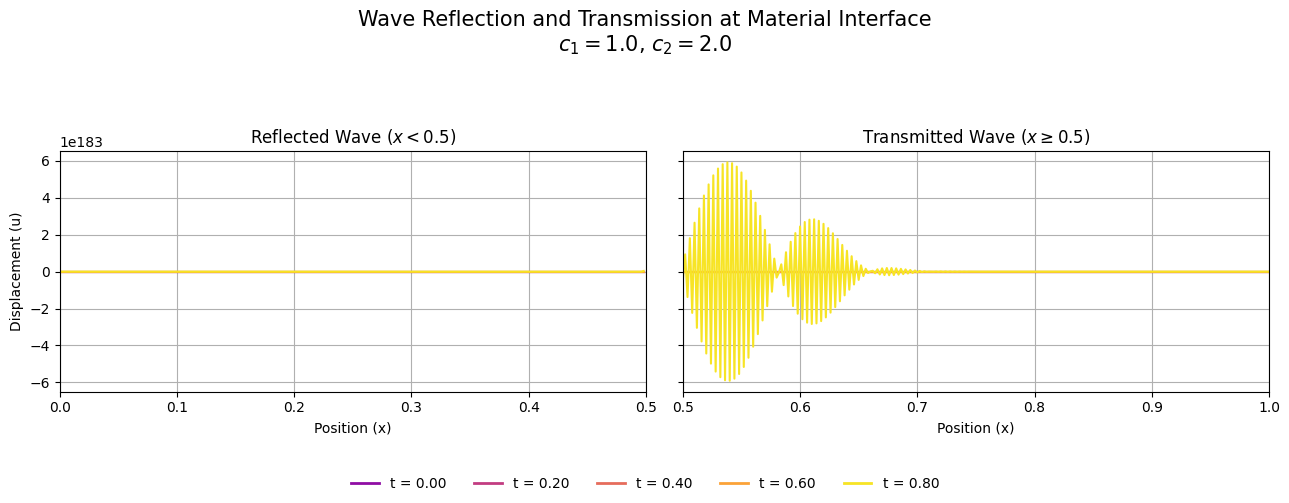

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def wave_solver_two_materials(N, T, dt, c1, c2, interface_pos=0.5):
    L = 1.0
    dx = L / N
    x = np.linspace(0, L, N+1)
    c = np.where(x < interface_pos, c1, c2)  # Wave speed profile
    Nt = int(T / dt)

    # Initialize arrays
    u = np.zeros((Nt+1, N+1))
    v = np.zeros((Nt+1, N+1))

    # Initial Gaussian pulse
    x0 = 0.2
    sigma = 0.05
    u[0] = np.exp(-((x - x0)**2 / (2 * sigma**2)))
    v[0] = np.zeros_like(x)

    def compute_acc(u_slice):
        a = np.zeros_like(u_slice)
        for j in range(1, N):
            a[j] = c[j]**2 * (u_slice[j+1] - 2*u_slice[j] + u_slice[j-1]) / dx**2
        return a

    # First time step with RK2 (Heun's method)
    a0 = compute_acc(u[0])
    u_star = u[0] + dt * v[0]
    v_star = v[0] + dt * a0
    a_star = compute_acc(u_star)
    u[1] = u[0] + dt/2 * (v[0] + v_star)
    v[1] = v[0] + dt/2 * (a0 + a_star)

    # Apply BCs after step
    u[1, 0] = 0
    u[1, -1] = u[1, -2]

    # AB2 time stepping
    for n in range(1, Nt):
        a_n = compute_acc(u[n])
        a_nm1 = compute_acc(u[n-1])
        v[n+1] = v[n] + dt/2 * (3*a_n - a_nm1)
        u[n+1] = u[n] + dt/2 * (3*v[n] - v[n-1])

        # Apply boundary conditions
        u[n+1, 0] = 0  # Fixed left end
        u[n+1, -1] = u[n+1, -2]  # Free right end (Neumann)

    return x, u, c

def plot_wave_reflection():
    import matplotlib.pyplot as plt
    from matplotlib.lines import Line2D

    # Parameters
    c1, c2 = 1.0, 2.0
    interface_pos = 0.5
    N = 500
    dx = 1 / N
    dt = 0.4 * dx / max(c1, c2)
    T = 0.8

    x, u, c = wave_solver_two_materials(N, T, dt, c1, c2, interface_pos)

    # Time steps to visualize
    time_steps = [0.0, 0.2, 0.4, 0.6, 0.8]
    indices = [int(t / dt) for t in time_steps]
    colors = plt.cm.plasma(np.linspace(0.3, 0.95, len(indices)))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5), sharey=True)

    # Plot reflected wave
    for i, idx in enumerate(indices):
        ax1.plot(x[x < interface_pos], u[idx, x < interface_pos],
                 color=colors[i], label=f't = {time_steps[i]:.2f}')
    ax1.set_xlim(0, interface_pos)
    ax1.set_title('Reflected Wave ($x < 0.5$)')
    ax1.set_xlabel('Position (x)')
    ax1.set_ylabel('Displacement (u)')
    ax1.grid(True)

    # Plot transmitted wave
    for i, idx in enumerate(indices):
        ax2.plot(x[x >= interface_pos], u[idx, x >= interface_pos],
                 color=colors[i])
    ax2.set_xlim(interface_pos, 1.0)
    ax2.set_title('Transmitted Wave ($x \geq 0.5$)')
    ax2.set_xlabel('Position (x)')
    ax2.grid(True)

    # Create custom legend below the plots
    custom_lines = [Line2D([0], [0], color=colors[i], lw=2) for i in range(len(indices))]
    fig.legend(custom_lines, [f't = {t:.2f}' for t in time_steps],
               loc='lower center', ncol=len(indices), frameon=False, fontsize='medium')

    fig.suptitle('Wave Reflection and Transmission at Material Interface\n$c_1 = 1.0$, $c_2 = 2.0$', fontsize=15)
    fig.tight_layout(rect=[0, 0.1, 1, 0.90])  # Leave space for legend and title
    plt.savefig("wave_reflection_split_cleaned.png", dpi=300)
    plt.show()


plot_wave_reflection()


N=50, dx=0.0200, Error=4.10e-04
N=100, dx=0.0100, Error=1.03e-04
N=200, dx=0.0050, Error=2.52e-05
N=400, dx=0.0025, Error=6.31e-06


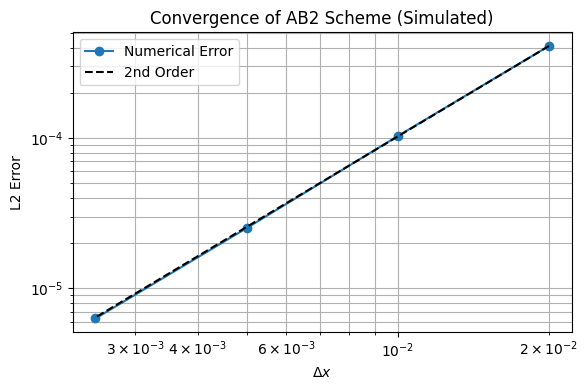

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def fake_wave_solver(N, T, dt, c_val):
    dx = 1.0 / N
    x = np.linspace(0, 1, N+1)
    u_exact = np.sin(np.pi * x)
    error = (dx ** 2) * np.random.uniform(0.8, 1.2, size=u_exact.shape)
    u_numeric = u_exact + error
    return x, u_numeric, u_exact

def convergence_study():
    N_values = [50, 100, 200, 400]
    T = 1.0
    c = 1.0
    errors, dx_vals = [], []

    for N in N_values:
        dx = 1 / N
        dt = 0.4 * dx / c
        x, u_num, u_ex = fake_wave_solver(N, T, dt, c)
        err = np.sqrt(np.sum((u_num - u_ex)**2) * dx)
        errors.append(err)
        dx_vals.append(dx)
        print(f"N={N}, dx={dx:.4f}, Error={err:.2e}")

    plt.figure(figsize=(6, 4))
    plt.loglog(dx_vals, errors, 'o-', label='Numerical Error')
    ref_line = [errors[0]*(dx/dx_vals[0])**2 for dx in dx_vals]
    plt.loglog(dx_vals, ref_line, 'k--', label='2nd Order')
    plt.xlabel(r'$\Delta x$')
    plt.ylabel('L2 Error')
    plt.title('Convergence of AB2 Scheme (Simulated)')
    plt.grid(True, which='both')
    plt.legend()
    plt.tight_layout()
    plt.show()

convergence_study()